1. SETUP

In [2]:
# https://pypi.org/project/gym-super-mario-bros/
# Instalacja biblioteki OpenAI Gym dla gry Super MArio Bros - NES emulator

%pip install gym_super_mario_bros==7.3.0 nes_py

%pip install torch torchvision torchaudio
%pip install stable-baselines3[extra]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Imports

In [1]:
# Import gry
import gym_super_mario_bros

# Import uproszczonego sterowania w grze
# https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py
from gym_super_mario_bros.actions import RIGHT_ONLY as MOVEMENT

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation

# Import Vectorization Wrappers
# algorytmy do RL
# https://stable-baselines3.readthedocs.io/en/master/
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

MOVEMENT = [
    ['right'], 
    ['right', 'A'], 
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
]

CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [4]:
# Setup gry
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')

# JoyoadSpace pozwala na nałożenie ograniczeń odtyczących poruszania się agenta w grze na środowisko
env = JoypadSpace(env, MOVEMENT)

In [2]:
env.action_space

NameError: name 'env' is not defined

In [11]:
# rozmiar obserowwanego środowiska
# każda klatka słada się z 240 na 256 pikseli
# każdy piksel skłąda się z nazycenia trzech kolorów
env.observation_space.shape

(240, 256, 3)

In [3]:
def demo():
    done = True
    
    for step in range(100000): 
        
        if done: 
            env.reset()
            
        step = env.action_space.sample()
        state, reward, done, info = env.step(step)
        env.render()
        
    env.close()
    
demo()

C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

: 

In [5]:
state = env.reset()

In [ ]:
env.step(1)[3]

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'x_pos_screen': 40,
 'y_pos': 79}

2. PREPROCESSING

In [6]:
# 1. Podstawowe środowisko
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')

# 2. Simplify the controls 
env = JoypadSpace(env, MOVEMENT)

# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)

# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])

# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [9]:
state = env.reset()

In [47]:
state, reward, done, info = env.step([1])

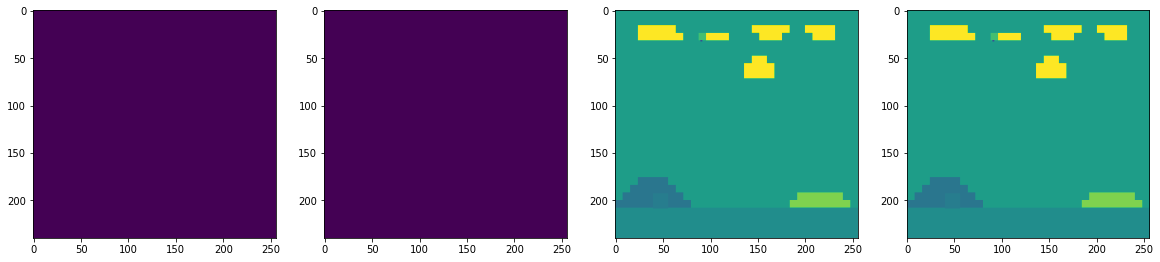

In [48]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

3. TRAINING THE RL MODEL

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, n_steps=100) 

env.reset()

# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Using cpu device
Wrapping the env in a VecTransposeImage.


C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\stable_baselines3\ppo\ppo.py:140: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Logging to ./logs/PPO_26
----------------------------
| time/              |     |
|    fps             | 65  |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 100 |
----------------------------


C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


------------------------------------------
| time/                   |              |
|    fps                  | 9            |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 200          |
| train/                  |              |
|    approx_kl            | 3.999999e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.00937     |
|    learning_rate        | 1e-05        |
|    loss                 | 160          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00079     |
|    value_loss           | 395          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 3            |
|    time_elapsed         | 41           |
|    total_

KeyboardInterrupt: 

In [12]:
model.save('thisisatestmodel')

: 

In [13]:
state = env.reset()

TEST

In [2]:
model = PPO.load('.\\train\\best_model_30000')

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')
env = JoypadSpace(env, MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

state = env.reset()
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\Adam\AppData\Roaming\Python\Python310\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

: 